## Что нужно сделать
Решите задачу классификации оттоковых клиентов телекома: для каждого клиента необходимо определить, перестанет он пользоваться услугами оператора в ближайшее время или нет.

In [610]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
import plotly.graph_objs as go
from sklearn.ensemble import RandomForestClassifier

In [611]:
pd.options.mode.copy_on_write = True
df=pd.read_csv('telecom_churn.csv')
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Сделайте первичную обработку данных:

1. Выбросите колонку State.

2. Колонки International plan и Voice mail plan закодируйте следующим образом: Yes замените на 1, а No на 0.

3. Переведите целевую переменную (Churn) в числа: True в 1, а False в 0.

In [612]:
df.drop('State', axis=1, inplace=True)

In [613]:
l=LabelEncoder()
df['International plan']=l.fit_transform(df['International plan'])
df['Voice mail plan']=l.fit_transform(df['Voice mail plan'])
df['Churn']=l.fit_transform(df['Churn'])

Выведите на экран первые строки изменённой таблицы, чтобы проверить, что все преобразования сработали.

In [614]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [615]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Account length          3333 non-null   int64  
 1   Area code               3333 non-null   int64  
 2   International plan      3333 non-null   int64  
 3   Voice mail plan         3333 non-null   int64  
 4   Number vmail messages   3333 non-null   int64  
 5   Total day minutes       3333 non-null   float64
 6   Total day calls         3333 non-null   int64  
 7   Total day charge        3333 non-null   float64
 8   Total eve minutes       3333 non-null   float64
 9   Total eve calls         3333 non-null   int64  
 10  Total eve charge        3333 non-null   float64
 11  Total night minutes     3333 non-null   float64
 12  Total night calls       3333 non-null   int64  
 13  Total night charge      3333 non-null   float64
 14  Total intl minutes      3333 non-null   

In [616]:
df.describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
Account length,3333.000000,101.064806,39.822106,1.000000,74.000000,101.000000,127.000000,243.000000
Area code,3333.000000,437.182418,42.371290,408.000000,408.000000,415.000000,510.000000,510.000000
International plan,3333.000000,0.096910,0.295879,0.000000,0.000000,0.000000,0.000000,1.000000
Voice mail plan,3333.000000,0.276628,0.447398,0.000000,0.000000,0.000000,1.000000,1.000000
Number vmail messages,3333.000000,8.099010,13.688365,0.000000,0.000000,0.000000,20.000000,51.000000
Total day minutes,3333.000000,179.775098,54.467389,0.000000,143.700000,179.400000,216.400000,350.800000
Total day calls,3333.000000,100.435644,20.069084,0.000000,87.000000,101.000000,114.000000,165.000000
Total day charge,3333.000000,30.562307,9.259435,0.000000,24.430000,30.500000,36.790000,59.640000
Total eve minutes,3333.000000,200.980348,50.713844,0.000000,166.600000,201.400000,235.300000,363.700000
Total eve calls,3333.000000,100.114311,19.922625,0.000000,87.000000,100.000000,114.000000,170.000000


In [617]:
print(df.duplicated().sum())

0


*Дубликатов, пропущенных значений - нет*


Создайте матрицу объект-признак X и вектор с целевой переменной (Churn) y.

In [618]:
X=df.drop('Churn', axis=1)
y=df['Churn']

Проверьте баланс классов. Является ли выборка сбалансированной?

In [619]:
df['Churn'].value_counts(sort=False)

,count
Churn,
0,2850
1,483


*По целевому показателю выборка не сбалансированная - данных с меньшим классом (положительное значение Churn) в 5,9 раз меньше, чем с отрицательным значением Churn*

Text(0.5, 1.0, 'Гистограмма распределения целевой переменной (Churn)')

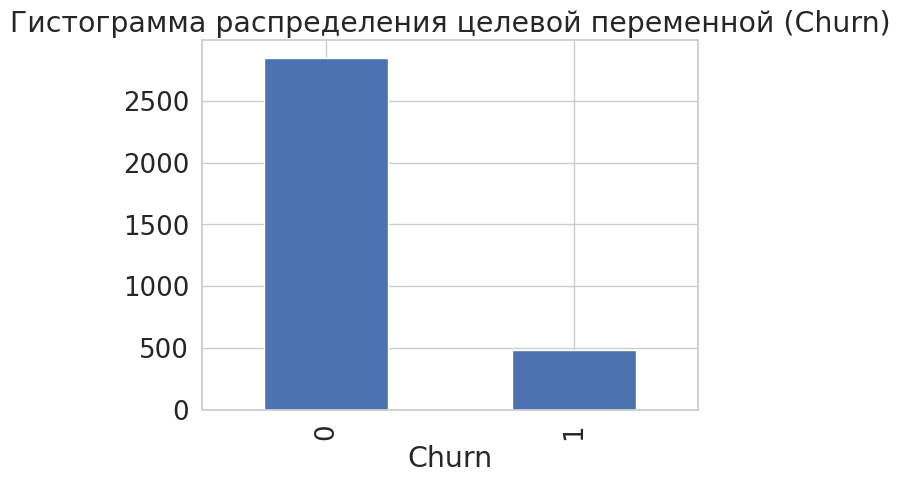

In [620]:
df['Churn'].value_counts().plot(kind='bar')
plt.title('Гистограмма распределения целевой переменной (Churn)')

In [621]:
class Model:
    def __init__(self, model, df=df):
      self.model=model
      self.df=df
      self.X=df.drop('Churn', axis=1)
      self.y=df['Churn']
      #Разбейте данные на тренировочную и тестовую части, размер тестовой части — 30%.
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size=0.3, stratify=self.y, random_state=42)
      self.confusion_mat=None
      self.accuracy_s = None
      self.precision_s = None
      self.recall_s = None
      self.f1_s = None
      self.roc_auc_s = None
      self.y_pred=None

    def scale_data(self):
      #Для линейных моделей очень важно масштабирование признаков. Поэтому отмасштабируйте признаки при помощи StandardScaler, обучив метод на тренировочных данных и применив его и к трейну, и к тесту.
      scaler=StandardScaler()
      self.X_train_s=scaler.fit_transform(self.X_train)
      self.X_test_s=scaler.transform(self.X_test)
      # После масштабирования признаков X_train и X_test перестали быть объектами типа pd.DataFrame, это неудобно. Приведите их снова к pd.DataFrame.
      self.X_train=pd.DataFrame(self.X_train_s, columns=self.X_train.columns)
      self.X_test=pd.DataFrame(self.X_test_s, columns=self.X_test.columns)

    def calculate_model(self):
        self.model.fit(self.X_train, self.y_train)
        self.y_pred=self.model.predict(self.X_test)
        print(classification_report(self.y_test, self.y_pred))
        self.confusion_mat = confusion_matrix(self.y_test, self.y_pred)
        self.accuracy_s = accuracy_score(self.y_test, self.y_pred)
        self.precision_s = precision_score(self.y_test, self.y_pred, average='binary')
        self.recall_s = recall_score(self.y_test, self.y_pred, average='binary')
        self.f1_s = f1_score(self.y_test, self.y_pred, average='binary')
        self.roc_auc_s = roc_auc_score(self.y_test, self.y_pred)
        print('Accuracy: ', self.accuracy_s)
        print('Precision: ', self.precision_s)
        print('Recall: ', self.recall_s)
        print('F1: ', self.f1_s)
        print('AUC: ', self.roc_auc_s)


    def show_small_heatmap(self):
        matrix=self.confusion_mat
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Матрица ошибок')
        plt.xlabel("Прогноз")
        plt.ylabel("Фактическое значение")
        plt.show();

    def show_roc_curve(self):
        #Предсказываем вероятности
        y_pred_proba=self.model.predict_proba(self.X_test)[:,1]
        # Строим кривую ROC
        fpr, tpr, thresholds = metrics.roc_curve(self.y_test, y_pred_proba)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-кривая')
        plt.show();

        auc=metrics.roc_auc_score(self.y_test, y_pred_proba)
        print('\n\n AUC: ', auc)

        trace = go.Scatter(x=fpr, y=tpr, mode='lines', name='AUC = %0.2f' % auc, line=dict(color='darkorange', width=2))
        reference_line = go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Reference Line', line=dict(color='navy', width=2, dash='dash'))
        fig=go.Figure(data=[trace, reference_line])
        fig.update_layout(title='ROC-кривая', xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')
        fig.show();


In [622]:
class Tree_Model(Model):
    def __init__(self, model, df=df):
      super().__init__(model, df)

    def show_tree(self):
      plt.figure(figsize=(15, 8))
      plot_tree(self.model, filled=True, feature_names=self.df.columns[:-1])
      plt.show();

    def show_feature_importance(self):
          feats={}
          for feature, importance in zip(self.df.columns, self.model.feature_importances_):
            feats[feature]=importance
          importances=(pd.DataFrame.from_dict(feats, orient='index')
                                  .rename(columns={0:'Gini-Importance'})
                                  .sort_values(by='Gini-Importance', ascending=False)
                                  .reset_index().rename(columns={'index': 'Features'}))

          plt.figure(figsize=(15, 8))
          sns.set(font_scale=5)
          sns.set(style='whitegrid', color_codes=True, font_scale=1.7)
          sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
          plt.xlabel('Importance', fontsize=25, weight='bold')
          plt.ylabel('Features', fontsize=25, weight='bold')
          plt.title('Feature Importance', fontsize=25, weight='bold')
          plt.show();
          display(importances)

Обучите на тренировочных данных с параметрами по умолчанию:

1) логистическую регрессию;

2) метод опорных векторов (с kernel='linear').

**Модель логистической регрессии:**

In [623]:
lr_model = Model(model=LogisticRegression(max_iter=1000), df=df)
lr_model.scale_data()
lr_model.calculate_model()

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1996
           1       0.55      0.22      0.31       338

    accuracy                           0.86      2334
   macro avg       0.71      0.59      0.62      2334
weighted avg       0.83      0.86      0.83      2334

Accuracy:  0.8607540702656384
Precision:  0.5481481481481482
Recall:  0.21893491124260356
F1:  0.3128964059196617
AUC:  0.5941868944990573


*Показатель Precision на уровне 0.548, показатель Recall 0.216 - крайне низкие параметры классификации, модель работает плохо.*

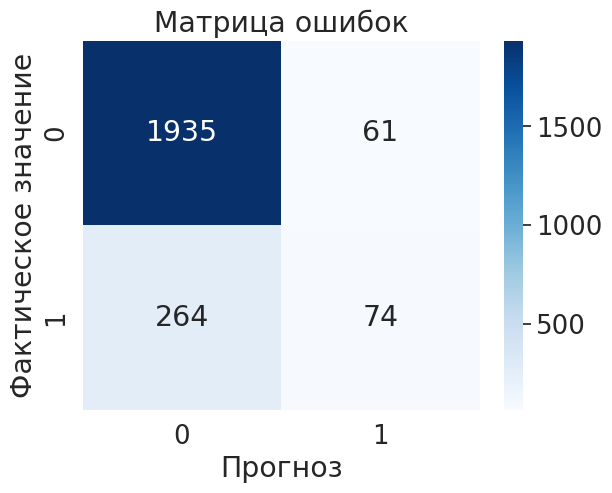

In [624]:
lr_model.show_small_heatmap()

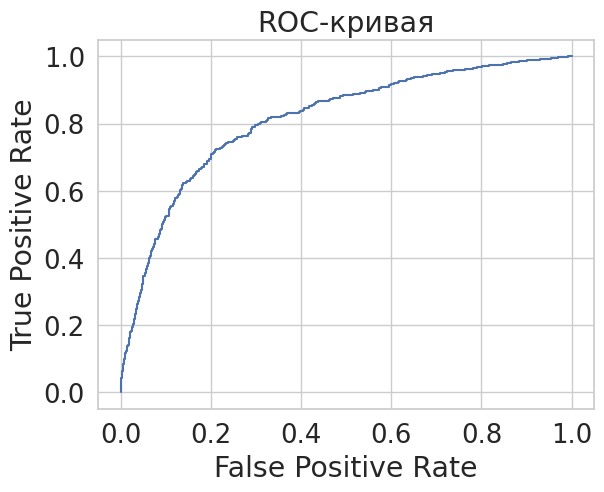



 AUC:  0.8125481732696161


In [625]:
lr_model.show_roc_curve()

*Показатель AUC (Area under Curve) - площади под кривой ROC - интерпретирует вероятность, с которой модель верно определит две точки (объекта), расположенные в разных классах, которые поданы ей на вход для анализа. В нашем случае это вероятность 81%. Показатель 50% (площадь под синей пунктирной кривой - вариант случайного выбора, рандомного угадывания). Однако мы помним, что в наших данных есть очень существенный дисбаланс классов по целевому признаку, поэтому значение показателя AUC на уровне 81% демонстрирует лишь нежелание модели правильно классифицировать объекты в меньший по численности класс, модель по-сути бесполезна, так как относит все объекты преимущественно к мажорному классу (предсказывает на всех данных отсуствие перехода к другому оператору). Основной в данном случае показатель - Recall - доля правильно предсказанный показаний, для Churn=True (клиент уходит) она составляет лишь 22%. То есть модель правильно предсказала 22% ушедших клиентов, что крайне мало.*

**Метод опорных векторов**

In [626]:
svc_model = Model(model=SVC(kernel='linear', probability=True), df=df)
svc_model.scale_data()
svc_model.calculate_model()

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      1996
           1       0.00      0.00      0.00       338

    accuracy                           0.86      2334
   macro avg       0.43      0.50      0.46      2334
weighted avg       0.73      0.86      0.79      2334

Accuracy:  0.8551842330762639
Precision:  0.0
Recall:  0.0
F1:  0.0
AUC:  0.5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



*Показатель Precision на уровне 0, но показатель Recall 0.00 - крайне низкие параметры классификации, модель работает плохо.*

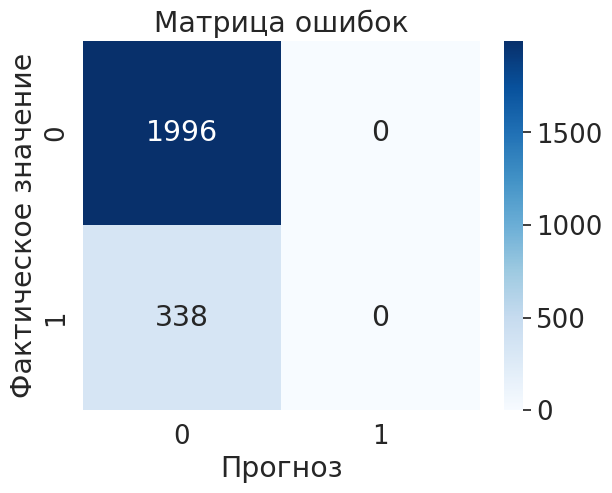

In [627]:
svc_model.show_small_heatmap()

*Еще очевиднее нежелание модели классифицировать объекты в область Churn=1, все объекты классифицируются в область Churn=0 (отсутствие перехода)*

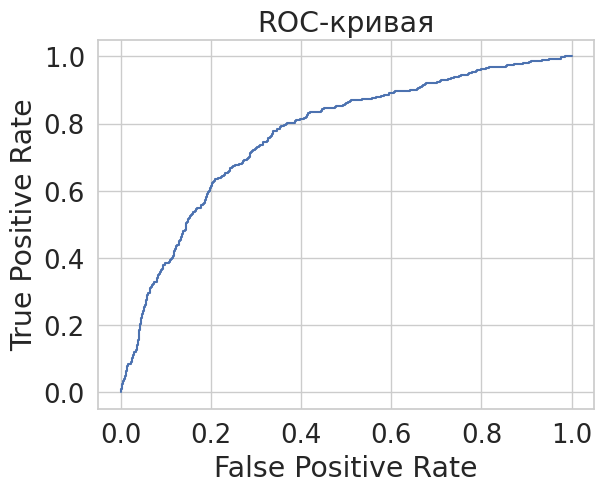



 AUC:  0.7678048404501311


In [628]:
svc_model.show_roc_curve()

*Значение показателя AUC на уровне 78%, модель демонстрирует нежелание правильно классифицировать объекты в меньший по численности класс, модель по-сути бесполезна, так как относит все объекты преимущественно к мажорному классу (предсказывает на всех данных отсуствие перехода к другому оператору). Основной в данном случае показатель - Recall - доля правильно предсказанный показаний, для Churn=True (клиент уходит) она составляет лишь 0%. То есть модель не ищет ушедших клиентов, что крайне мало. *

## Модель Решающих деревьев (с масштабированием признаков)

Теперь обучите решающее дерево с параметрами по умолчанию на тренировочных данных, сделайте предсказание на тесте. Используйте метрику для оценки.

In [629]:
tree_model_scale = Tree_Model(model=DecisionTreeClassifier(max_depth=7, min_samples_leaf=4), df=df)
tree_model_scale.scale_data()
tree_model_scale.calculate_model()

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1996
           1       0.85      0.68      0.76       338

    accuracy                           0.94      2334
   macro avg       0.90      0.83      0.86      2334
weighted avg       0.93      0.94      0.93      2334

Accuracy:  0.9361610968294773
Precision:  0.8461538461538461
Recall:  0.6834319526627219
F1:  0.7561374795417348
AUC:  0.8311949342471927


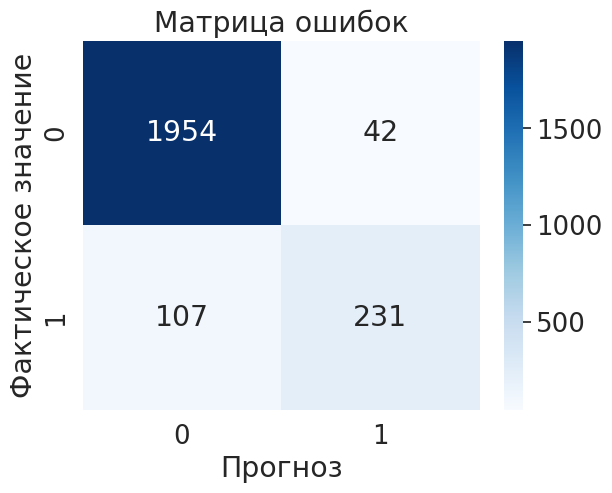

In [630]:
tree_model_scale.show_small_heatmap()

*В модели решающих деревьев мы наблюдаем более уверенное желание модели классифицировать объекты в минорный класс (Churn=True) - из 338 случаев перехода к другому оператору модель верно определила 231.*

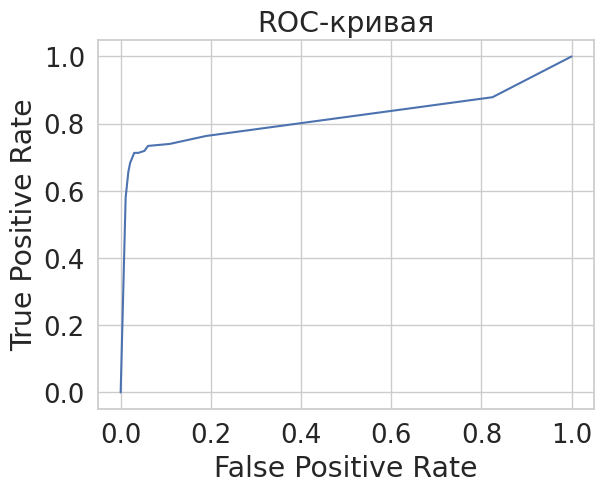



 AUC:  0.8201565853600692


In [631]:
tree_model_scale.show_roc_curve()

*Значение показателя AUC выросло по сравнению с предыдущими моделями несущественно, но модель стала лучше, что видно по показателю Recall для минорного класса, который увеличился до 68%. Около 2/3 переходов модель находит и классифицирует верно.*

*Визуализируем дерево*

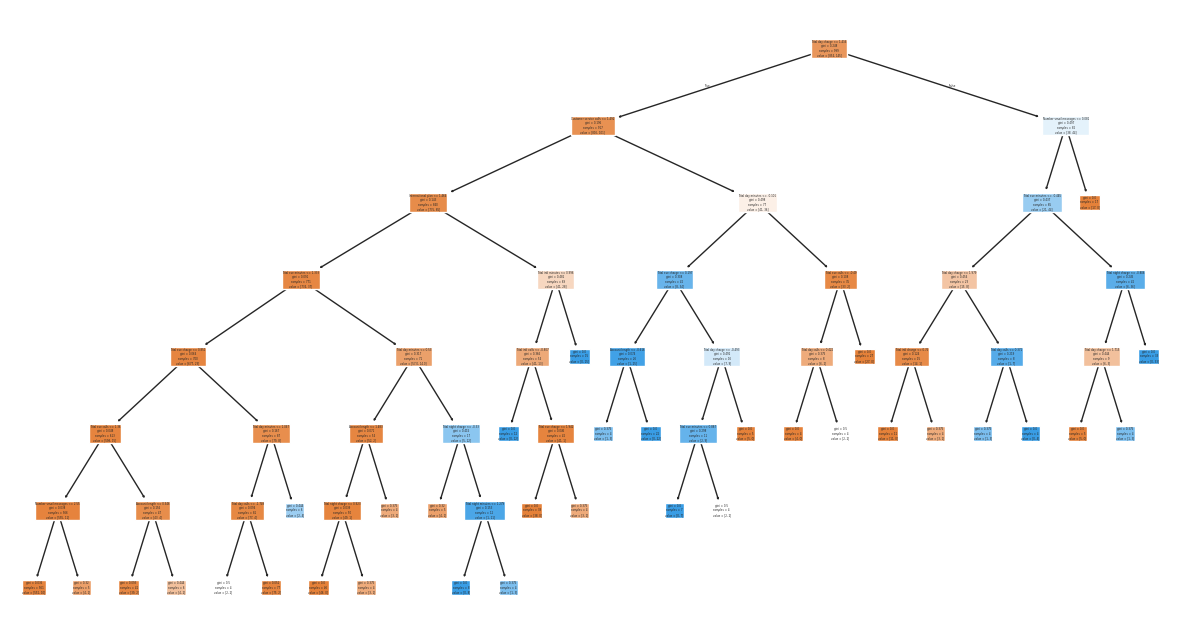

In [632]:
tree_model_scale.show_tree()

 *Изучим важность признаков в их влиянии на целевой признак Churn:*

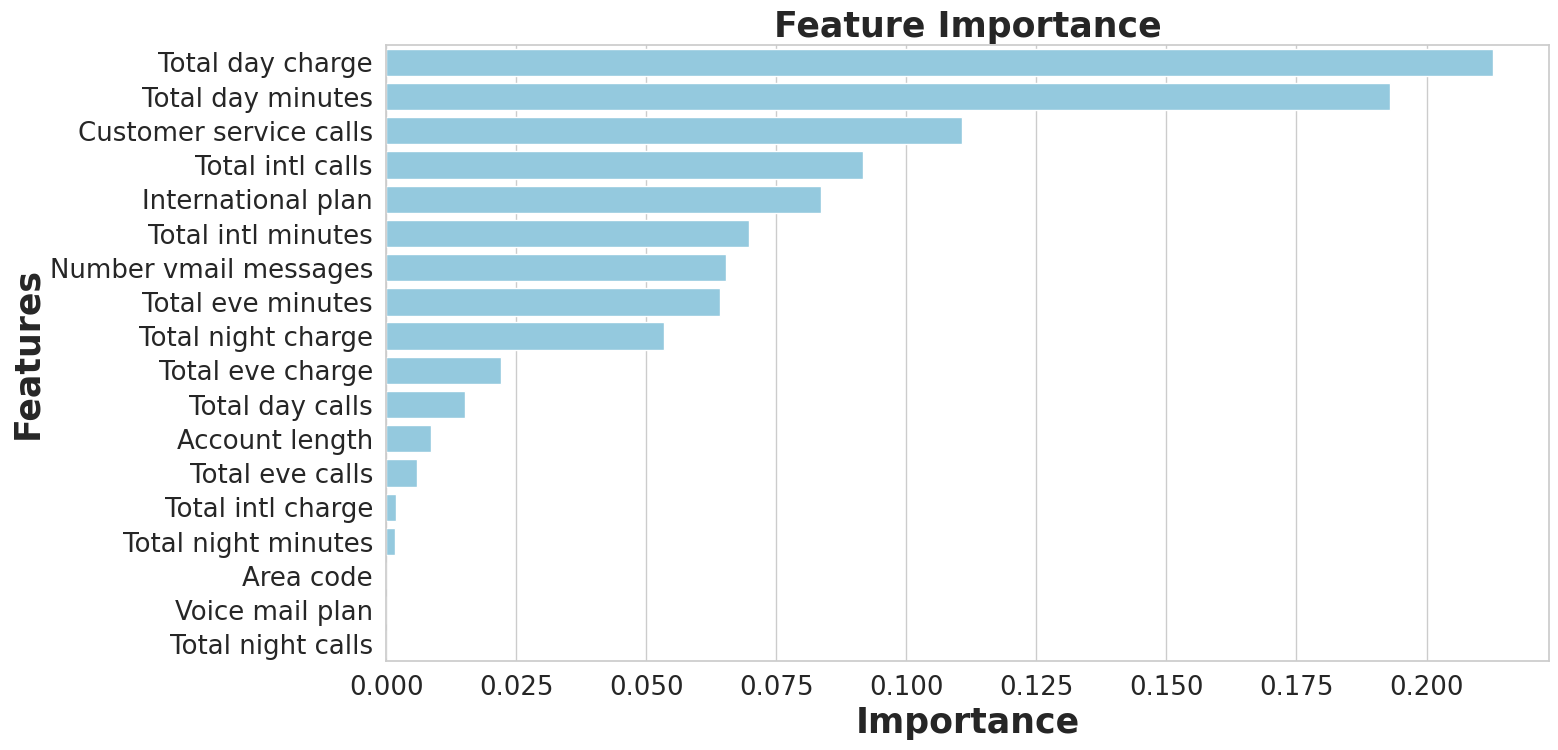

,Features,Gini-Importance
0,Total day charge,0.212835
1,Total day minutes,0.192956
2,Customer service calls,0.110670
3,Total intl calls,0.091678
4,International plan,0.083576
5,Total intl minutes,0.069755
6,Number vmail messages,0.065344
7,Total eve minutes,0.064239
8,Total night charge,0.053452
9,Total eve charge,0.022165


In [633]:
tree_model_scale.show_feature_importance()

## Модель Решающих деревьев (без масштабирования признаков)

In [634]:
tree_model = Tree_Model(model=DecisionTreeClassifier(max_depth=7, min_samples_leaf=4), df=df)
tree_model.calculate_model()

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1996
           1       0.84      0.67      0.74       338

    accuracy                           0.93      2334
   macro avg       0.89      0.82      0.85      2334
weighted avg       0.93      0.93      0.93      2334

Accuracy:  0.9331619537275064
Precision:  0.8395522388059702
Recall:  0.665680473372781
F1:  0.7425742574257426
AUC:  0.8220686936002182


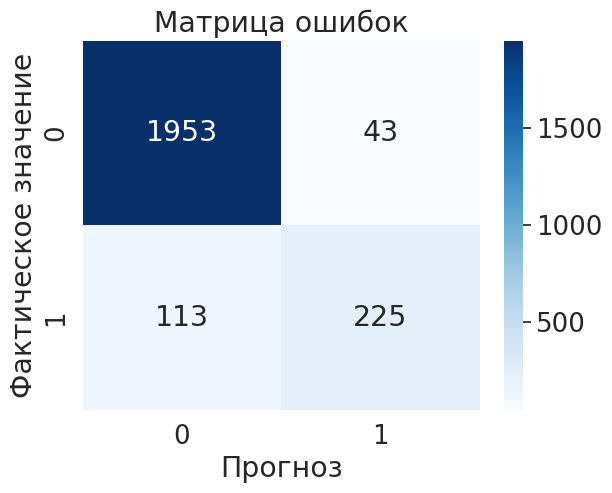

In [635]:
tree_model.show_small_heatmap()

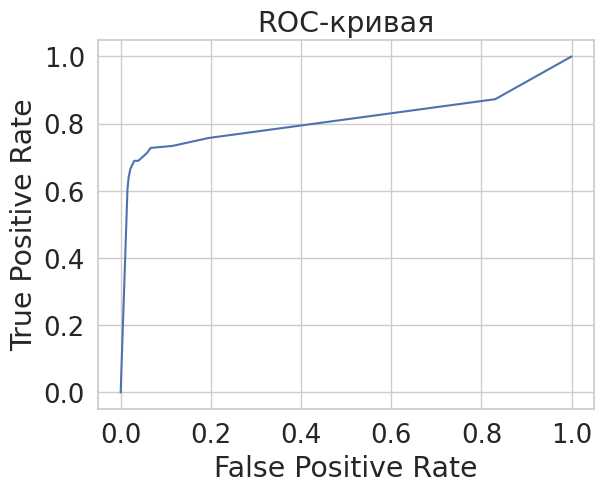



 AUC:  0.8118233508436992


In [636]:
tree_model.show_roc_curve()

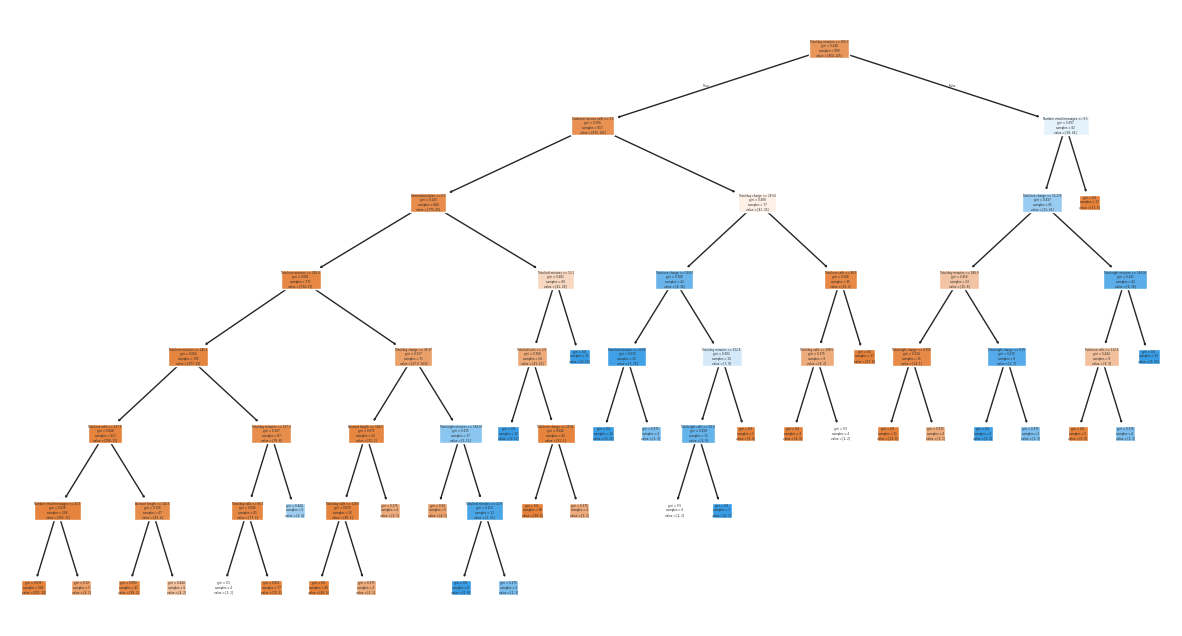

In [637]:
tree_model.show_tree()

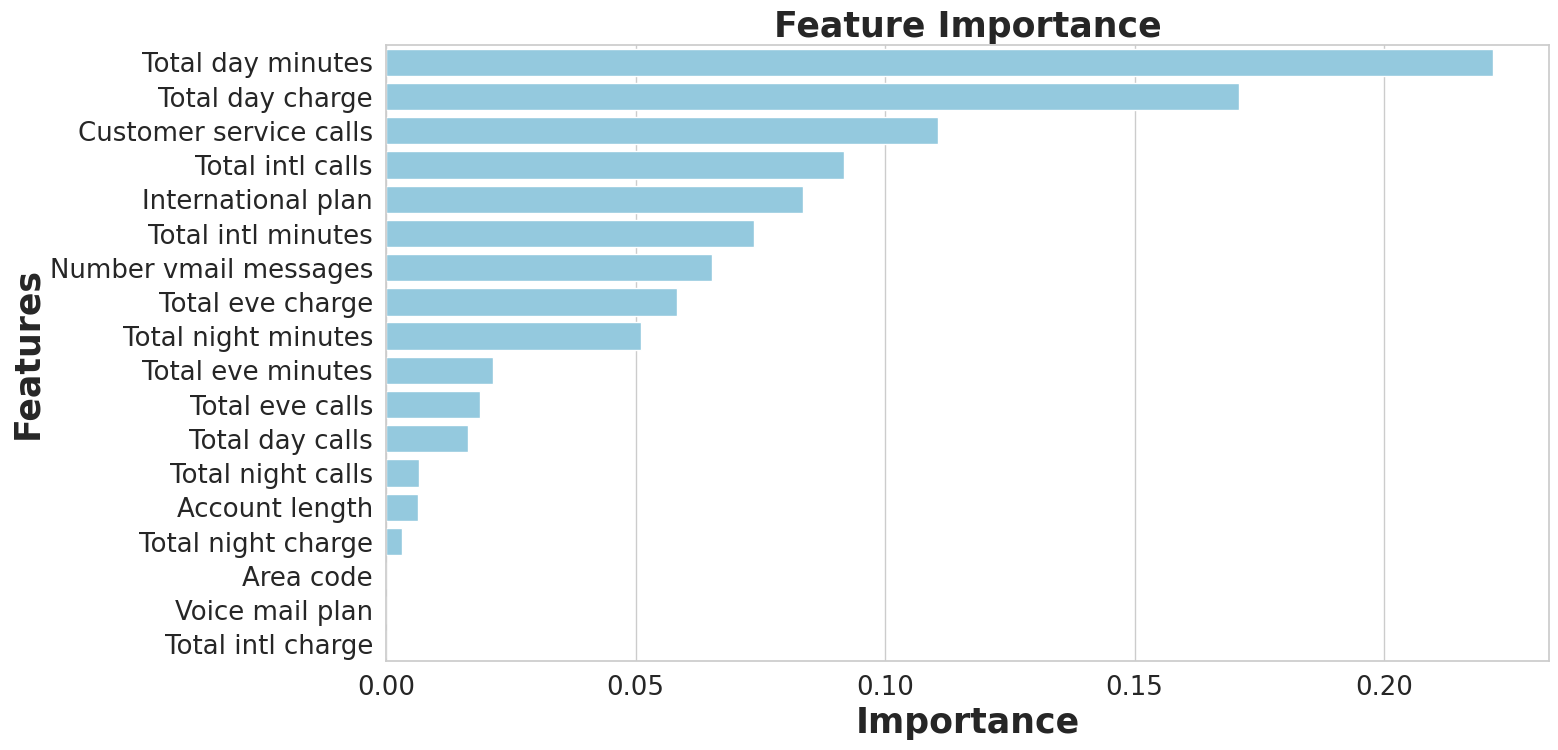

,Features,Gini-Importance
0,Total day minutes,0.221891
1,Total day charge,0.171015
2,Customer service calls,0.110670
3,Total intl calls,0.091678
4,International plan,0.083576
5,Total intl minutes,0.073654
6,Number vmail messages,0.065344
7,Total eve charge,0.058326
8,Total night minutes,0.051081
9,Total eve minutes,0.021519


In [638]:
tree_model.show_feature_importance()

*Показатель AUC также почти не изменится если отказаться от масштабирования признаков*

*Выясним, нужно ли бороться с дисбалансом классов. Используем изменение параметров модели деревьев решений на сбалансированные по классам веса, и посмотрим, что даст наилучший результат.*

In [639]:
tree_ugrate_model_scale = Tree_Model(model=DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, class_weight='balanced'), df=df)
tree_ugrate_model_scale.scale_data()
tree_ugrate_model_scale.calculate_model()

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1996
           1       0.60      0.71      0.65       338

    accuracy                           0.89      2334
   macro avg       0.77      0.82      0.79      2334
weighted avg       0.90      0.89      0.89      2334

Accuracy:  0.8886032562125107
Precision:  0.5965346534653465
Recall:  0.7130177514792899
F1:  0.6495956873315364
AUC:  0.8156772124129916


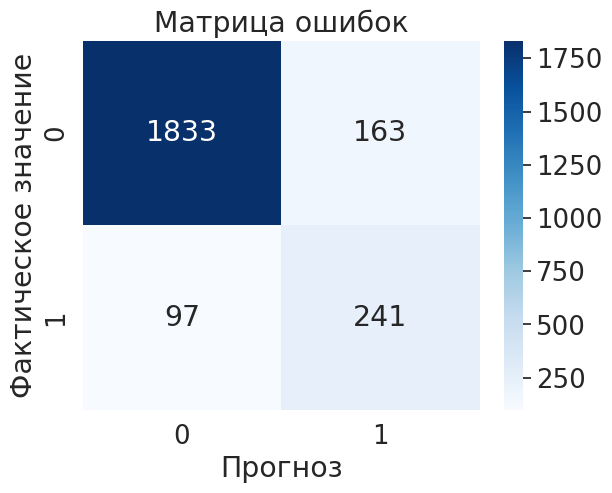

In [640]:
tree_ugrate_model_scale.show_small_heatmap()

*Показатель Recall поднимается до 78%, но показатель Precision (сколько из предсказанных переходов на тестовой выборке в реальности были переходами) упал до 59%*

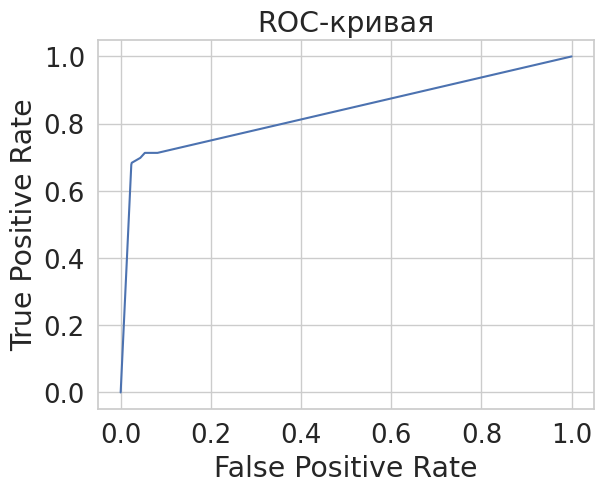



 AUC:  0.8354490045179115


In [641]:
tree_ugrate_model_scale.show_roc_curve()

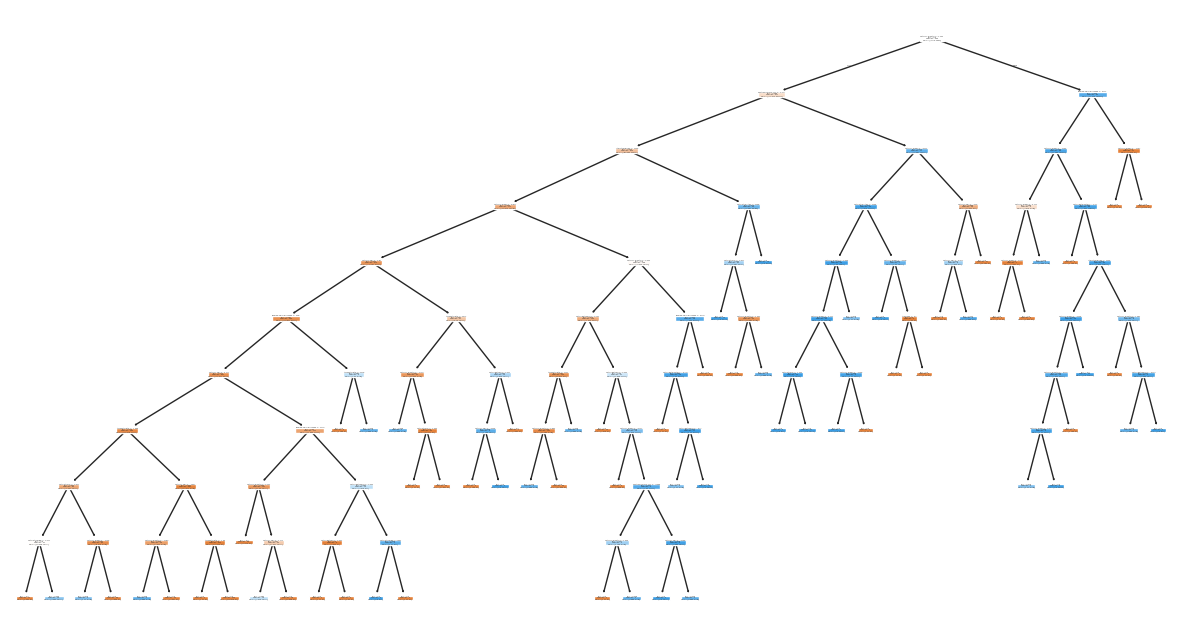

In [642]:
tree_ugrate_model_scale.show_tree()

*Видим, что в данном случае стандартные методы борьбы с дисбалансом классов не позволили улучшить модель, также как и масштабирование данных. Однако увеличение глубины дерева и уменьшение min_samples_leaf увеличило AUC до 83 %*

Попробуем применить еще одну модель классификаци - RandomForestClassifier, также основанную на "деревьях" решений

In [643]:
random_tree_model_scale = Tree_Model(model=RandomForestClassifier(max_depth=11, min_samples_leaf=3, class_weight='balanced'), df=df)
random_tree_model_scale.scale_data()
random_tree_model_scale.calculate_model()

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1996
           1       0.84      0.64      0.72       338

    accuracy                           0.93      2334
   macro avg       0.89      0.81      0.84      2334
weighted avg       0.93      0.93      0.93      2334

Accuracy:  0.929305912596401
Precision:  0.8365758754863813
Recall:  0.636094674556213
F1:  0.7226890756302521
AUC:  0.8075262951939383


Показатель Recall снизился до 65%, но показатель Precision (сколько из предсказанных переходов на тестовой выборке в реальности были переходами) вырос до 84%.

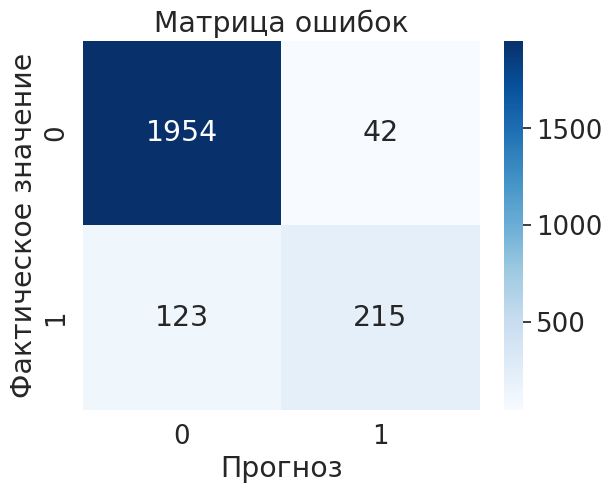

In [644]:
random_tree_model_scale.show_small_heatmap()

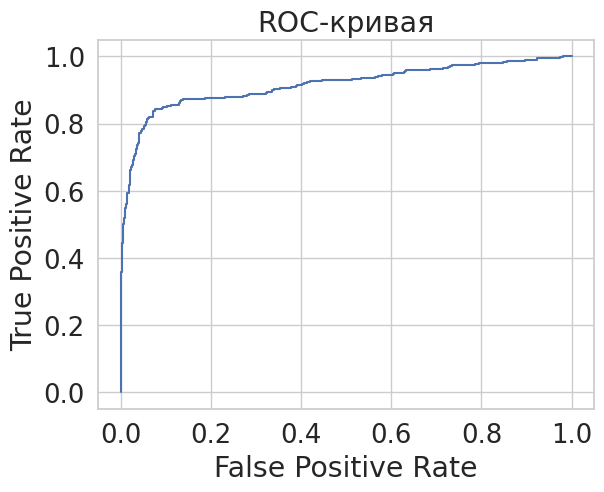



 AUC:  0.914564335772136


In [645]:
random_tree_model_scale.show_roc_curve()

*Показатель AUC (ROC) удалось поднять таким образом до 91%*

*В данном исследовании мы увидели, что модель DecisionTree дает хорошие результаты в задаче классификации по сравнению с другими моделями. Масштабирование данных не позволяет улучшить качество модели в этом случае. Также не ухудшает качество модели дисбаланс классов у целевого признака - модель "из коробки" отлично справляется с такими данными и не требует дополнительных манипуляций. Альтернативный вариант модели дерева решений (RandomForestClassifier) позволяет незначительно повысить качество предсказаний модели.*
